<a href="https://colab.research.google.com/github/PotoyanGroup/Seq2Ensemble/blob/main/ColabOpenAWSEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup the software

In [1]:
#@title Run this cell to set working environment
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:36
🔁 Restarting kernel...


In [ ]:
#@title Run this cell to install required software (OpenMM, OpenAWSEM, Stride, BLAST ...)
%%capture
%%shell
#1. Install OpenMM and core dependencies
conda install -c conda-forge openmm pdbfixer mdtraj biopython matplotlib numpy pandas ipykernel nglview

#2. Download openawsem
git clone https://github.com/PotoyanGroup/openawsem

#3. Download pdb_seqres
wget ftp://ftp.wwpdb.org/pub/pdb/derived_data/pdb_seqres.txt
mv pdb_seqres.txt openawsem/

#4. Download and isntall stride
wget http://webclu.bio.wzw.tum.de/stride/stride.tar.gz
mkdir stride_loc && tar -xf stride.tar.gz -C ./stride_loc
cd stride_loc && make

#5. Download and isntall BLAST (needed only for multi-fragment simulations)
#wget https://ftp.ncbi.nlm.nih.gov/blast/executables/blast+/LATEST/ncbi-blast-2.13.0+-src.tar.gz
#mkdir blast_loc && tar  -xf ncbi-blast-2.13.0+-src.tar.gz
#cd ncbi-blast-2.13.0+-src.tar.gz && ./configure
#cd ncbi-blast-2.13.0+-src.tar.gz && make

### Create Project and Run simulation

Choose **either of the two options below** to provide input structure. Do not click on both, otherwise the last option will be used for the simulation.

In [ ]:
#@title Option-1: Specify a PDB ID
import Bio
from Bio.PDB import PDBList
import shutil, os

PDB_ID='1R69' #@param {type:"string"}
PDB_ID = PDB_ID.lower()
 
#if os.path.exists(pdb_name): os.remove(pdb_name)

pdbl = PDBList()
pdbl.retrieve_pdb_file(PDB_ID, pdir='./')
shutil.copyfile(f'pdb{PDB_ID}.ent', 'input.pdb')

'input.pdb'

In [ ]:
#@title Option-2: Upload a PDB file
from google.colab import files
import os

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  os.rename(fn, 'input.pdb')

In [ ]:
#@title Run a simulation with AWSEM CG force-field
#@title Number fields
Temperature = 300.0 #@param {type:"number"}
Timesteps = 1000000 #@param {type:"number"}

!export PATH={$PATH}:/content/stride_loc
!export OPENAWSEM_LOCATION=/content/openawsem/

# Create project 
!python3 /content/openawsem/mm_create_project.py input.pdb

# Run simulation 
!python3 mm_run.py input  --steps $Timesteps --tempStart $Temperature --tempEnd $Temperature -f forces_setup.py

Chains info read from crystal_structure.pdb, chains to simulate:  A
/usr/local/lib/python3.7/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1001
  PDBConstructionWarning,
/usr/local/lib/python3.7/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1001
  PDBConstructionWarning,
/usr/local/lib/python3.7/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1001
  PDBConstructionWarning,
/usr/local/lib/python3.7/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1001
  PDBConstructionWarning,
/usr/local/lib/python3.7/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1001
  PDBConstructionWarning,
protein: input, length: 63
/usr/local/lib/python3.7/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: I

### Visualize the data

In [ ]:
#@title Run this cell to load visualization libraries.
import mdtraj as md
import nglview as nv
import pandas as pd
import matplotlib.pyplot as plt

def viz_q_e(file='info.dat'):

  data = pd.read_csv(file, sep='\s+')

  fig, ax = plt.subplots(ncols=2)
  ax[0].plot(data['Steps'], data['Q'])
  ax[0].set_ylabel('Fraction of native contacts')
  ax[0].set_xlabel('Time Steps')

  ax[1].plot(data['Steps'], data['Total'], color='red')
  ax[1].set_ylabel('Energy, kj/mol')
  ax[1].set_xlabel('Time Steps')
  fig.tight_layout()


def viz_traj(file='movie.dcd', top='native.pdb'):

  from google.colab import output
  output.enable_custom_widget_manager()

  view = nv.show_mdtraj(traj)
  return view

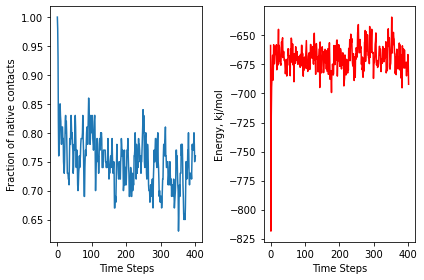

In [ ]:
#Check equilibration here
viz_q_e()

In [ ]:
#Close the pop up window and re-run the cell for animation to work
viz_traj()

NGLWidget(max_frame=401)